In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
from PIL import Image
from pathlib import Path
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report
from keras.preprocessing import image


In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
TRAIN_PATH = '/content/gdrive/MyDrive/Colab Notebooks/big_cat/train'
TEST_PATH = '/content/gdrive/MyDrive/Colab Notebooks/big_cat/test'
vALID_PATH = '/content/gdrive/MyDrive/Colab Notebooks/big_cat/valid'

In [4]:
def create_df(DIR_PATH):

  FOLDER_PATH = Path(DIR_PATH)

  file_paths = list(FOLDER_PATH.glob('**/*.jpg'))

  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

  file_paths = pd.Series(file_paths, name='File_Paths').astype(str)
  labels = pd.Series(labels, name='Labels')

  df = pd.concat([file_paths, labels], axis=1)

  return df

In [5]:
df = create_df(TRAIN_PATH)

df

,File_Paths,Labels
0,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,LIONS
1,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,LIONS
2,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,LIONS
3,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,LIONS
4,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,LIONS
...,...,...
2334,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,SNOW LEOPARD
2335,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,SNOW LEOPARD
2336,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,SNOW LEOPARD
2337,/content/gdrive/MyDrive/Colab Notebooks/big_ca...,SNOW LEOPARD


In [6]:
df['Labels'].value_counts()

Labels
JAGUAR             238
TIGER              237
PUMA               236
AFRICAN LEOPARD    236
CARACAL            236
CHEETAH            235
OCELOT             233
SNOW LEOPARD       231
CLOUDED LEOPARD    229
LIONS              228
Name: count, dtype: int64

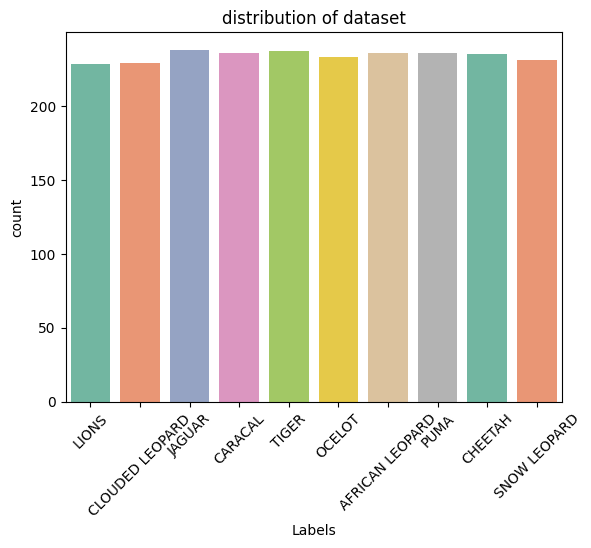

In [7]:
plt.title('distribution of dataset')
sns.countplot(data=df, x=df['Labels'], hue=df['Labels'], palette='Set2')
plt.xticks(rotation=45)

plt.show()

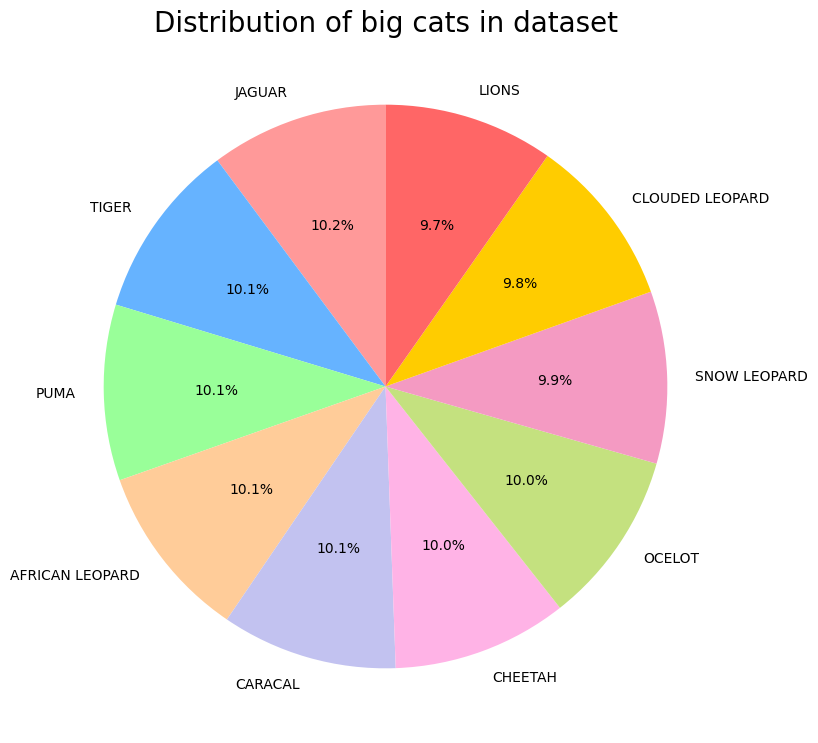

In [8]:
label_counts = df['Labels'].value_counts()

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f','#f49ac2','#ffcc00','#ff6666']

plt.figure(figsize=(8, 9))
plt.pie(x=label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)

plt.title('Distribution of big cats in dataset', fontsize=20)
plt.axis('equal')
plt.show()

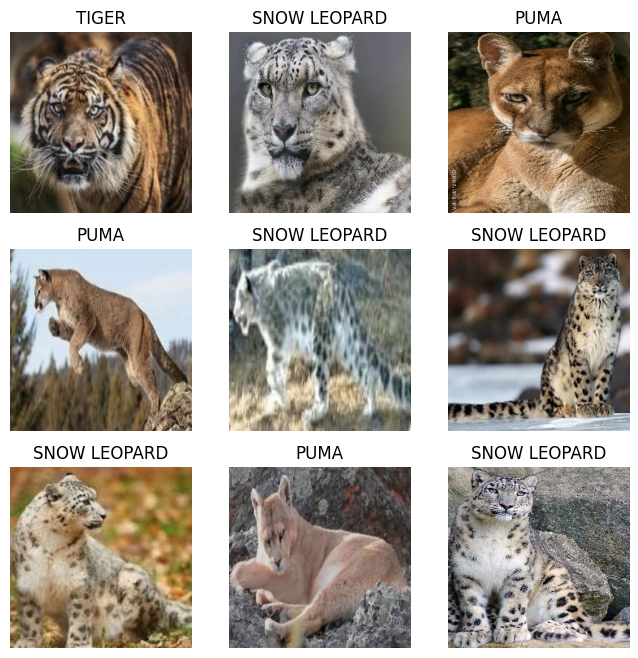

In [9]:
random_idx = np.random.randint(0, len(df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat):
  ax.imshow(Image.open(df['File_Paths'][random_idx[i]]))
  ax.set_title(df['Labels'][random_idx[i]])
  ax.axis('off')

plt.show()

In [10]:
test_df = create_df(TEST_PATH)
valid_df = create_df(vALID_PATH)

test_df.shape, valid_df.shape

((50, 2), (50, 2))

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='File_Paths',
    y_col='Labels',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='File_Paths',
    y_col='Labels',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=True,
    seed=42
)


test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File_Paths',
    y_col='Labels',
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False

)

Found 2339 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.


In [12]:
def create_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  x = base_model.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(len(set(df['Labels'])), activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [13]:
model = create_model()
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
74/74 [==============================] - 35s 324ms/step - loss: 4.1210 - accuracy: 0.5395 - val_loss: 0.8895 - val_accuracy: 0.7600
Epoch 2/10
74/74 [==============================] - 12s 166ms/step - loss: 0.3064 - accuracy: 0.8961 - val_loss: 0.5770 - val_accuracy: 0.7800
Epoch 3/10
74/74 [==============================] - 13s 167ms/step - loss: 0.0987 - accuracy: 0.9778 - val_loss: 0.5912 - val_accuracy: 0.8400
Epoch 4/10
74/74 [==============================] - 13s 169ms/step - loss: 0.0407 - accuracy: 0.9940 - val_loss: 0.3825 - val_accuracy: 0.8800
Epoch 5/10
74/74 [==============================] - 12s 165ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.4330 - val_accuracy: 0.8600
Epoch 6/10
74/74 [==============================] - 13s 178ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.4221 - val_accuracy: 0.8600
Epoch 7/10
74/74 [==============================] - 13s 177ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.4358 - val_accuracy: 0.8800

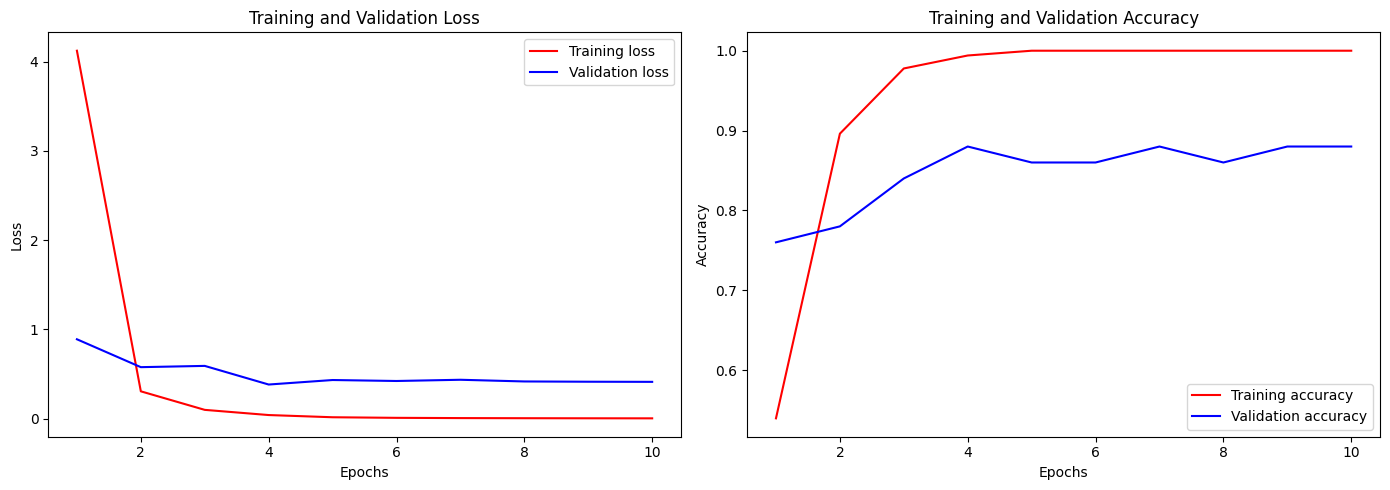

In [15]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 [==============================] - 8s 8s/step - loss: 0.2802 - accuracy: 0.9400
Test Loss: 0.2802180349826813, Test Accuracy: 0.9399999976158142


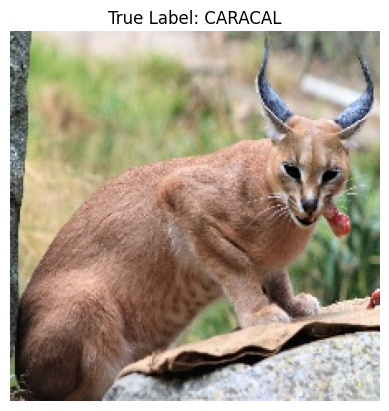

1/1 [==============================] - 0s 20ms/step
Predicted Label: CARACAL


In [34]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_df['Labels'])

def show_random_img():

  random_index = random.randint(0, len(test_df) - 1)
  random_image_path = test_df.iloc[random_index]['File_Paths']
  true_label = test_df.iloc[random_index]['Labels']

  img = image.load_img(random_image_path, target_size=(224, 224))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'True Label: {true_label}')
  plt.show()

  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img /= 255.0


  prediction = model.predict(img)
  predicted_label = label_encoder.classes_[np.argmax(prediction)]

  print(f'Predicted Label: {predicted_label}')


show_random_img()

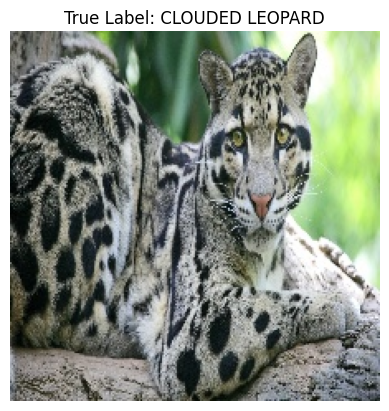

1/1 [==============================] - 0s 31ms/step
Predicted Label: CLOUDED LEOPARD


In [31]:
show_random_img()